# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
#FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 46kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

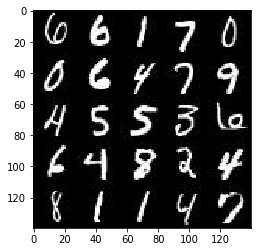

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

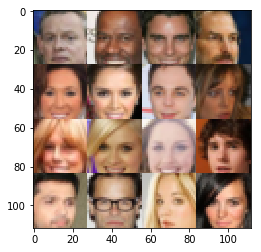

In [3]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape = (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape = (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1,256, 5, strides=2,padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2,padding='same')
        do3 = tf.nn.dropout(x3, 0.8)
        bn3 = tf.layers.batch_normalization(do3, training=True)
        relu3 = tf.maximum(alpha*bn3,bn3)
        
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z,7*7*512)
        
        x1 = tf.reshape(x1,(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha * x1,x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim,5,strides=1,padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smoth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logtis_real = discriminator(input_real,reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logtis_real,
                                                                         labels=tf.ones_like(d_model_real)*(1-smoth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    is_train = tf.placeholder(tf.bool)
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                 # Run optimizers
                _ = sess.run(d_opt,
                             feed_dict={input_z: batch_z,
                                        input_real: batch_images,
                                        lr: learning_rate})
                _ = sess.run(g_opt, 
                             feed_dict={input_z: batch_z, 
                                        input_real: batch_images,
                                        lr: learning_rate})
                                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    #Print the current image
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
        saver.save(sess, './generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4848... Generator Loss: 4.2632
Epoch 1/2... Discriminator Loss: 0.3661... Generator Loss: 5.9731
Epoch 1/2... Discriminator Loss: 2.3071... Generator Loss: 12.0328
Epoch 1/2... Discriminator Loss: 0.7778... Generator Loss: 2.0557
Epoch 1/2... Discriminator Loss: 0.7277... Generator Loss: 2.0881
Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 0.9502
Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 1.0487
Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 1.8150
Epoch 1/2... Discriminator Loss: 1.1669... Generator Loss: 1.2579
Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 1.6998


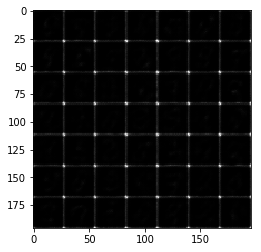

Epoch 1/2... Discriminator Loss: 1.0543... Generator Loss: 1.5261
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 1.5020
Epoch 1/2... Discriminator Loss: 1.0440... Generator Loss: 0.9132
Epoch 1/2... Discriminator Loss: 1.2999... Generator Loss: 0.6949
Epoch 1/2... Discriminator Loss: 0.9603... Generator Loss: 1.2748
Epoch 1/2... Discriminator Loss: 1.0468... Generator Loss: 1.0468
Epoch 1/2... Discriminator Loss: 1.0479... Generator Loss: 1.8675
Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 1.1424
Epoch 1/2... Discriminator Loss: 0.9662... Generator Loss: 1.4226
Epoch 1/2... Discriminator Loss: 1.0287... Generator Loss: 0.9962


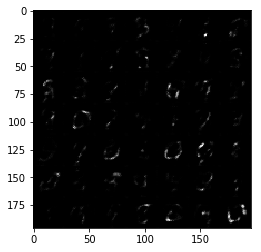

Epoch 1/2... Discriminator Loss: 1.1151... Generator Loss: 2.5190
Epoch 1/2... Discriminator Loss: 1.0015... Generator Loss: 0.9913
Epoch 1/2... Discriminator Loss: 0.9807... Generator Loss: 1.4986
Epoch 1/2... Discriminator Loss: 0.9710... Generator Loss: 1.1984
Epoch 1/2... Discriminator Loss: 0.9083... Generator Loss: 1.4014
Epoch 1/2... Discriminator Loss: 1.0403... Generator Loss: 1.1466
Epoch 1/2... Discriminator Loss: 1.4660... Generator Loss: 0.5709
Epoch 1/2... Discriminator Loss: 0.9776... Generator Loss: 1.2088
Epoch 1/2... Discriminator Loss: 1.3146... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.1798... Generator Loss: 2.0857


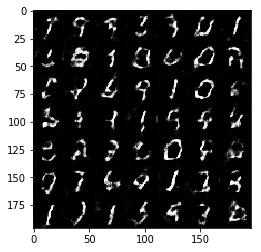

Epoch 1/2... Discriminator Loss: 1.1111... Generator Loss: 0.9951
Epoch 1/2... Discriminator Loss: 1.3645... Generator Loss: 2.2990
Epoch 1/2... Discriminator Loss: 1.1723... Generator Loss: 1.0155
Epoch 1/2... Discriminator Loss: 1.4678... Generator Loss: 0.5009
Epoch 1/2... Discriminator Loss: 1.1058... Generator Loss: 1.2957
Epoch 1/2... Discriminator Loss: 1.6551... Generator Loss: 0.4595
Epoch 1/2... Discriminator Loss: 0.9085... Generator Loss: 1.1982
Epoch 1/2... Discriminator Loss: 1.2087... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 1.2365... Generator Loss: 0.6530
Epoch 1/2... Discriminator Loss: 1.2228... Generator Loss: 1.6565


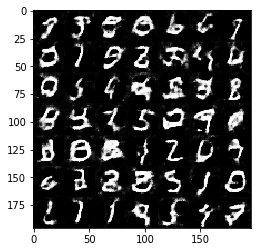

Epoch 1/2... Discriminator Loss: 1.1569... Generator Loss: 1.3360
Epoch 1/2... Discriminator Loss: 1.1334... Generator Loss: 2.0300
Epoch 1/2... Discriminator Loss: 1.0612... Generator Loss: 0.9305
Epoch 1/2... Discriminator Loss: 1.1280... Generator Loss: 0.8104
Epoch 1/2... Discriminator Loss: 0.9773... Generator Loss: 1.1524
Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 0.7886
Epoch 1/2... Discriminator Loss: 1.1055... Generator Loss: 1.8395
Epoch 1/2... Discriminator Loss: 1.2910... Generator Loss: 0.6678
Epoch 1/2... Discriminator Loss: 0.9879... Generator Loss: 1.0376
Epoch 1/2... Discriminator Loss: 1.0233... Generator Loss: 0.9976


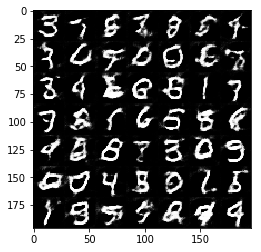

Epoch 1/2... Discriminator Loss: 0.9857... Generator Loss: 2.4257
Epoch 1/2... Discriminator Loss: 1.2602... Generator Loss: 0.7584
Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 0.8141
Epoch 1/2... Discriminator Loss: 0.9489... Generator Loss: 1.3965
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 1.6638
Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 1.0034
Epoch 1/2... Discriminator Loss: 1.0586... Generator Loss: 1.0398
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 1.3032
Epoch 1/2... Discriminator Loss: 0.9713... Generator Loss: 1.0235
Epoch 1/2... Discriminator Loss: 0.9526... Generator Loss: 1.0165


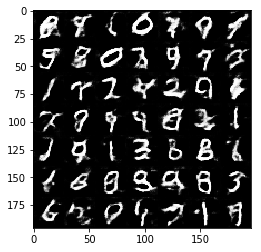

Epoch 1/2... Discriminator Loss: 1.2837... Generator Loss: 0.6191
Epoch 1/2... Discriminator Loss: 1.0176... Generator Loss: 1.5167
Epoch 1/2... Discriminator Loss: 1.2238... Generator Loss: 0.7525
Epoch 1/2... Discriminator Loss: 0.9561... Generator Loss: 1.7091
Epoch 1/2... Discriminator Loss: 1.0876... Generator Loss: 1.9020
Epoch 1/2... Discriminator Loss: 0.8925... Generator Loss: 1.5072
Epoch 1/2... Discriminator Loss: 0.9131... Generator Loss: 1.2943
Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 1.6307
Epoch 1/2... Discriminator Loss: 1.1071... Generator Loss: 0.8791
Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 0.6882


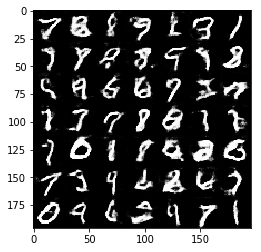

Epoch 1/2... Discriminator Loss: 0.9370... Generator Loss: 1.2265
Epoch 1/2... Discriminator Loss: 0.8549... Generator Loss: 1.7382
Epoch 1/2... Discriminator Loss: 1.0099... Generator Loss: 1.6669
Epoch 1/2... Discriminator Loss: 0.9755... Generator Loss: 1.0455
Epoch 1/2... Discriminator Loss: 0.7921... Generator Loss: 1.9828
Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 2.3989
Epoch 1/2... Discriminator Loss: 1.3152... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 0.7496... Generator Loss: 1.3800
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 0.5673
Epoch 1/2... Discriminator Loss: 0.9342... Generator Loss: 1.1393


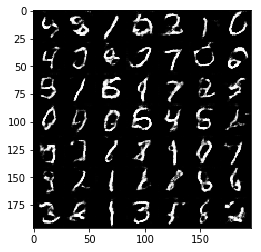

Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 0.6942
Epoch 1/2... Discriminator Loss: 0.8269... Generator Loss: 1.3545
Epoch 1/2... Discriminator Loss: 1.1282... Generator Loss: 1.0580
Epoch 1/2... Discriminator Loss: 1.0710... Generator Loss: 0.8702
Epoch 1/2... Discriminator Loss: 0.8314... Generator Loss: 1.4437
Epoch 1/2... Discriminator Loss: 1.1105... Generator Loss: 0.8296
Epoch 1/2... Discriminator Loss: 0.8440... Generator Loss: 1.1833
Epoch 1/2... Discriminator Loss: 0.8774... Generator Loss: 1.2651
Epoch 1/2... Discriminator Loss: 1.1755... Generator Loss: 0.7511
Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 0.6041


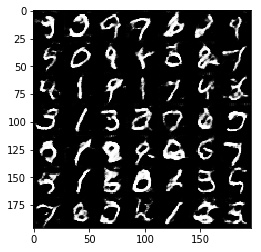

Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 1.0670
Epoch 1/2... Discriminator Loss: 0.8948... Generator Loss: 1.4514
Epoch 1/2... Discriminator Loss: 1.7922... Generator Loss: 0.3911
Epoch 2/2... Discriminator Loss: 0.8384... Generator Loss: 1.2333
Epoch 2/2... Discriminator Loss: 0.8772... Generator Loss: 1.1166
Epoch 2/2... Discriminator Loss: 1.4749... Generator Loss: 0.5362
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 1.7752
Epoch 2/2... Discriminator Loss: 0.9755... Generator Loss: 1.0854
Epoch 2/2... Discriminator Loss: 0.9534... Generator Loss: 1.0925
Epoch 2/2... Discriminator Loss: 1.1546... Generator Loss: 2.3890


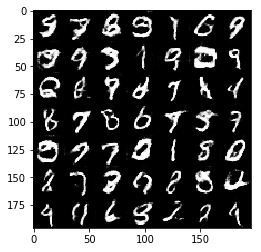

Epoch 2/2... Discriminator Loss: 1.0789... Generator Loss: 1.5884
Epoch 2/2... Discriminator Loss: 1.0744... Generator Loss: 0.8551
Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 0.7248
Epoch 2/2... Discriminator Loss: 0.9670... Generator Loss: 1.0686
Epoch 2/2... Discriminator Loss: 0.9423... Generator Loss: 1.6596
Epoch 2/2... Discriminator Loss: 1.0266... Generator Loss: 0.9606
Epoch 2/2... Discriminator Loss: 0.9073... Generator Loss: 1.1512
Epoch 2/2... Discriminator Loss: 0.9655... Generator Loss: 0.9791
Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 1.9179
Epoch 2/2... Discriminator Loss: 0.9460... Generator Loss: 1.2016


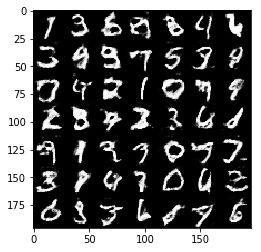

Epoch 2/2... Discriminator Loss: 0.9443... Generator Loss: 1.0081
Epoch 2/2... Discriminator Loss: 0.9281... Generator Loss: 2.0179
Epoch 2/2... Discriminator Loss: 1.1850... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 0.9483... Generator Loss: 1.1384
Epoch 2/2... Discriminator Loss: 1.6936... Generator Loss: 0.4275
Epoch 2/2... Discriminator Loss: 1.5471... Generator Loss: 0.4883
Epoch 2/2... Discriminator Loss: 0.8869... Generator Loss: 1.1992
Epoch 2/2... Discriminator Loss: 1.1866... Generator Loss: 0.8325
Epoch 2/2... Discriminator Loss: 0.7940... Generator Loss: 1.4428
Epoch 2/2... Discriminator Loss: 0.7551... Generator Loss: 1.6907


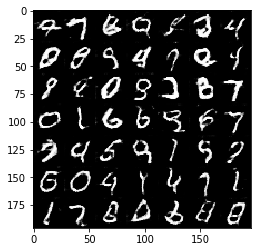

Epoch 2/2... Discriminator Loss: 1.2263... Generator Loss: 0.6720
Epoch 2/2... Discriminator Loss: 0.8651... Generator Loss: 1.2361
Epoch 2/2... Discriminator Loss: 0.8952... Generator Loss: 1.2999
Epoch 2/2... Discriminator Loss: 0.9096... Generator Loss: 1.0896
Epoch 2/2... Discriminator Loss: 0.8027... Generator Loss: 1.3411
Epoch 2/2... Discriminator Loss: 1.4329... Generator Loss: 0.5579
Epoch 2/2... Discriminator Loss: 1.0231... Generator Loss: 1.0194
Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 0.8771
Epoch 2/2... Discriminator Loss: 0.8965... Generator Loss: 2.2790
Epoch 2/2... Discriminator Loss: 0.5968... Generator Loss: 1.9380


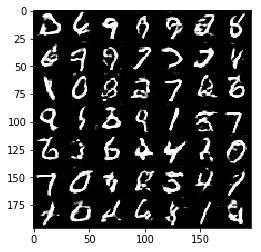

Epoch 2/2... Discriminator Loss: 2.5370... Generator Loss: 0.2217
Epoch 2/2... Discriminator Loss: 1.0753... Generator Loss: 0.9743
Epoch 2/2... Discriminator Loss: 1.0255... Generator Loss: 1.7851
Epoch 2/2... Discriminator Loss: 1.2014... Generator Loss: 1.6134
Epoch 2/2... Discriminator Loss: 0.9238... Generator Loss: 1.0192
Epoch 2/2... Discriminator Loss: 1.0139... Generator Loss: 2.2237
Epoch 2/2... Discriminator Loss: 0.7786... Generator Loss: 1.4543
Epoch 2/2... Discriminator Loss: 0.6137... Generator Loss: 1.7323
Epoch 2/2... Discriminator Loss: 0.6849... Generator Loss: 2.1002
Epoch 2/2... Discriminator Loss: 1.4467... Generator Loss: 0.5644


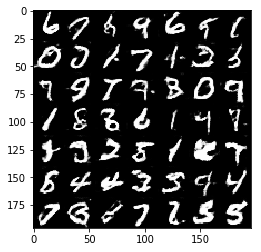

Epoch 2/2... Discriminator Loss: 0.8710... Generator Loss: 1.2235
Epoch 2/2... Discriminator Loss: 1.0126... Generator Loss: 0.8490
Epoch 2/2... Discriminator Loss: 0.7755... Generator Loss: 1.8105
Epoch 2/2... Discriminator Loss: 0.7438... Generator Loss: 2.1788
Epoch 2/2... Discriminator Loss: 1.5665... Generator Loss: 0.5712
Epoch 2/2... Discriminator Loss: 0.6300... Generator Loss: 2.0058
Epoch 2/2... Discriminator Loss: 1.0457... Generator Loss: 2.7133
Epoch 2/2... Discriminator Loss: 1.1893... Generator Loss: 0.8166
Epoch 2/2... Discriminator Loss: 0.8079... Generator Loss: 1.5537
Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 0.6441


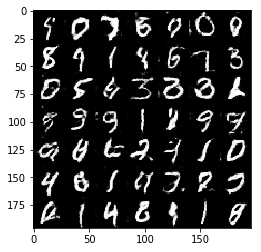

Epoch 2/2... Discriminator Loss: 1.3212... Generator Loss: 0.6895
Epoch 2/2... Discriminator Loss: 0.8975... Generator Loss: 2.0021
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.4389
Epoch 2/2... Discriminator Loss: 0.8389... Generator Loss: 1.2466
Epoch 2/2... Discriminator Loss: 0.6170... Generator Loss: 1.9031
Epoch 2/2... Discriminator Loss: 0.7089... Generator Loss: 1.9542
Epoch 2/2... Discriminator Loss: 0.9492... Generator Loss: 1.0407
Epoch 2/2... Discriminator Loss: 1.1157... Generator Loss: 0.8529
Epoch 2/2... Discriminator Loss: 1.2562... Generator Loss: 0.9032
Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 1.0752


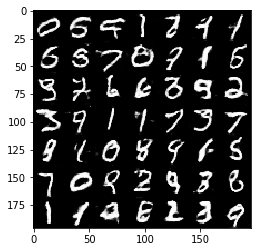

Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 1.5993
Epoch 2/2... Discriminator Loss: 2.1265... Generator Loss: 0.2990
Epoch 2/2... Discriminator Loss: 0.8402... Generator Loss: 1.2605
Epoch 2/2... Discriminator Loss: 1.1975... Generator Loss: 0.7845
Epoch 2/2... Discriminator Loss: 0.8097... Generator Loss: 1.3607
Epoch 2/2... Discriminator Loss: 0.7771... Generator Loss: 1.4770
Epoch 2/2... Discriminator Loss: 0.7096... Generator Loss: 1.6414
Epoch 2/2... Discriminator Loss: 0.6788... Generator Loss: 2.1401
Epoch 2/2... Discriminator Loss: 0.5581... Generator Loss: 2.0201
Epoch 2/2... Discriminator Loss: 1.4294... Generator Loss: 0.6159


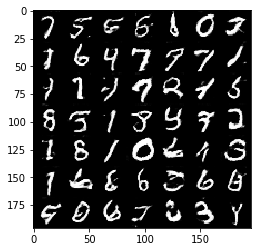

Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.6114
Epoch 2/2... Discriminator Loss: 0.8638... Generator Loss: 1.1109
Epoch 2/2... Discriminator Loss: 0.9904... Generator Loss: 0.9856
Epoch 2/2... Discriminator Loss: 0.8259... Generator Loss: 2.6186
Epoch 2/2... Discriminator Loss: 0.6902... Generator Loss: 1.6600
Epoch 2/2... Discriminator Loss: 0.9234... Generator Loss: 1.0734
Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.6221
Epoch 2/2... Discriminator Loss: 2.5174... Generator Loss: 0.2471
Epoch 2/2... Discriminator Loss: 0.6216... Generator Loss: 1.8224
Epoch 2/2... Discriminator Loss: 0.5579... Generator Loss: 2.3213


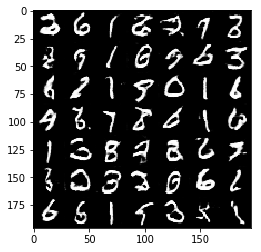

Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 1.4681
Epoch 2/2... Discriminator Loss: 0.6095... Generator Loss: 1.7527
Epoch 2/2... Discriminator Loss: 0.6430... Generator Loss: 1.9792
Epoch 2/2... Discriminator Loss: 2.2427... Generator Loss: 0.3308
Epoch 2/2... Discriminator Loss: 0.8601... Generator Loss: 1.4095
Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 1.0321
Epoch 2/2... Discriminator Loss: 1.4089... Generator Loss: 0.5730


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 9.6099... Generator Loss: 0.0045
Epoch 1/1... Discriminator Loss: 0.5853... Generator Loss: 4.3110
Epoch 1/1... Discriminator Loss: 2.0411... Generator Loss: 13.6213
Epoch 1/1... Discriminator Loss: 3.3980... Generator Loss: 0.4668
Epoch 1/1... Discriminator Loss: 3.3632... Generator Loss: 0.0955
Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 2.5113
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 2.4246
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 0.5696... Generator Loss: 1.8786


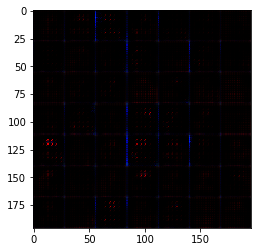

Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 1.9415
Epoch 1/1... Discriminator Loss: 0.4754... Generator Loss: 2.5871
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.4829
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 2.0306
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 2.6707
Epoch 1/1... Discriminator Loss: 2.2433... Generator Loss: 0.2118
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.7096... Generator Loss: 0.4179
Epoch 1/1... Discriminator Loss: 2.6466... Generator Loss: 0.1167


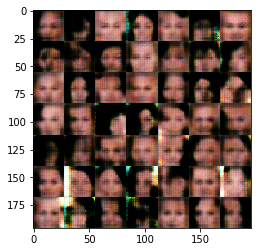

Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 1.3177
Epoch 1/1... Discriminator Loss: 4.4207... Generator Loss: 4.3698
Epoch 1/1... Discriminator Loss: 1.7293... Generator Loss: 1.5090
Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 0.5064
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.7638... Generator Loss: 0.3210
Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.4130
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.7099... Generator Loss: 0.3712


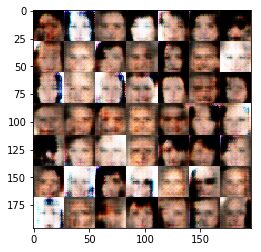

Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.4470
Epoch 1/1... Discriminator Loss: 1.6262... Generator Loss: 0.3633
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.4757
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.4077
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 1.1571
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 1.3530
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.6381


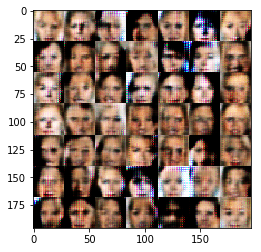

Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.4696
Epoch 1/1... Discriminator Loss: 2.0287... Generator Loss: 0.2467
Epoch 1/1... Discriminator Loss: 1.6319... Generator Loss: 1.5709
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.4439
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.4576
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.7244... Generator Loss: 0.3320


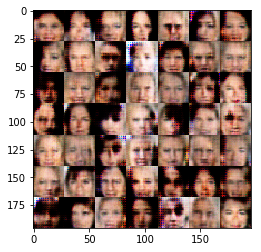

Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 2.4160... Generator Loss: 0.1487
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 1.5171
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 1.5060
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 1.2023
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 1.3801
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7678


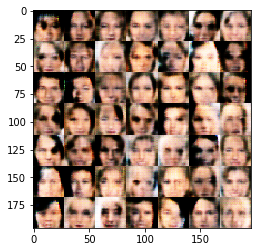

Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 1.5560
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 1.2579
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 1.2555
Epoch 1/1... Discriminator Loss: 3.0596... Generator Loss: 0.0763
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.4285
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 1.0137


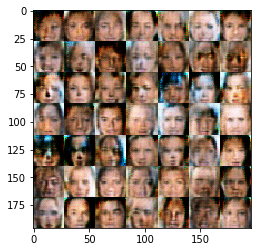

Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.6518... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.9884
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 1.1665
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7663


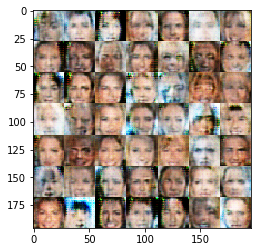

Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 1.3002
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.4429
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 2.0430... Generator Loss: 0.2204
Epoch 1/1... Discriminator Loss: 1.7140... Generator Loss: 1.7079
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.5426


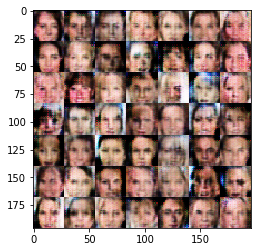

Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 1.4041
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.8700


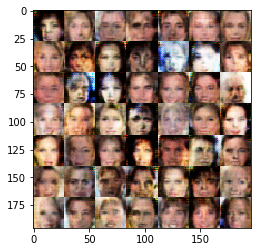

Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.7112... Generator Loss: 0.3661
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.3908
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 1.4285
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.5952... Generator Loss: 1.0159


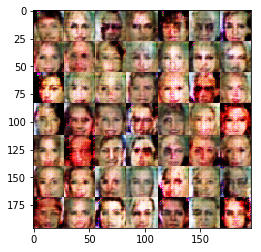

Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.4764
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.9409... Generator Loss: 1.7589
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.9562
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.7977


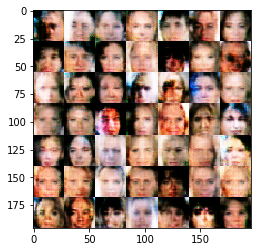

Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 1.1265
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 1.9055... Generator Loss: 1.4095
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 1.2277


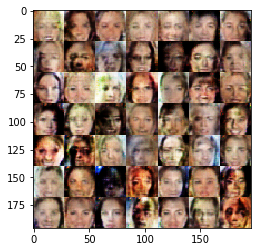

Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 1.2266
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.4329
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 1.1619
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 1.2190
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.5751


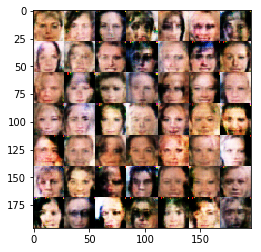

Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 1.2096
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 1.1537
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6064


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [ ]:
print("Done")

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.